# **Import Required libraries**

In [1]:
import os
import cv2
import random
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from random import shuffle
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from tensorflow.keras.models import Model
from google.colab.patches import cv2_imshow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import CosineSimilarity
from tensorflow.keras.applications import InceptionV3
from keras import optimizers, losses, activations, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, log_loss, accuracy_score
from tensorflow.keras.metrics import CosineSimilarity as CosineSimilarityMetric
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Dense,Convolution2D, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model

# **Get Dataset (Cropped faces)**

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
extract_dir = '/content/drive/MyDrive/CroppedFaces'
# List the extracted files and folders
extracted_files = os.listdir(extract_dir)
print("Extracted files and folders:")
print(len(extracted_files))

Extracted files and folders:
105


# **Data Preprocessing**

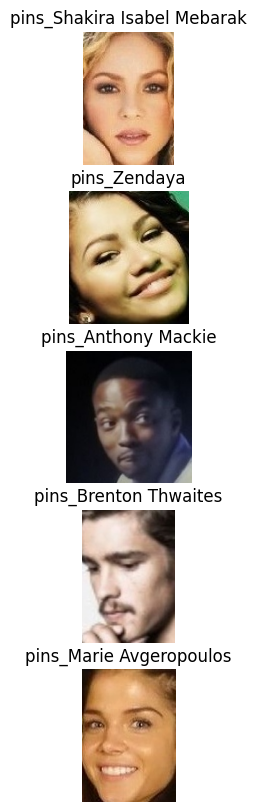

In [4]:
#Display a sample of images
def show_sample_images(images_dir, num_samples_per_class=1, num_classes=5):
    classes = os.listdir(images_dir)
    classes = random.sample(classes, num_classes)

    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(images_dir, class_name)
        class_images = os.listdir(class_dir)
        class_images = random.sample(class_images, num_samples_per_class)
        for j, image_name in enumerate(class_images):
            img_path = os.path.join(class_dir, image_name)
            img = mpimg.imread(img_path)
            plt.subplot(num_classes, num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)

    plt.show()

# Display a sample of 5 classes with 1 sample image each
show_sample_images(extract_dir, num_classes=5, num_samples_per_class=1)

# **Handle Dataset**

In [5]:
dataset=[]
count=0
for file in os.listdir(extract_dir):
    path=os.path.join(extract_dir,file)
    t=0
    for im in os.listdir(path):
        image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=(120,120))
        image=img_to_array(image)
        image=image/255.0
        t+=1
        dataset.append([image,count])
    count+=1

In [6]:
data,labels0=zip(*dataset)
labels1=to_categorical(labels0)
data=np.array(data)
labels=np.array(labels1)

# **Split data**

In [7]:
X_train,X_test,y_train,y_test=train_test_split(data,labels,test_size=0.2,random_state=44)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28088, 120, 120, 3)
(7023, 120, 120, 3)
(28088, 105)
(7023, 105)


# **Modeling**

In [9]:
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

local_weights_file = '/content/drive/MyDrive/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'
pre_trained_model = InceptionV3(input_shape = (120, 120, 3),
                                include_top = True,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
     layer.trainable = False

#pre_trained_model.summary()
last_layer = pre_trained_model.get_layer('mixed6')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output and add additional dense layers for classification
x = layers.Flatten()(last_output)
print(x.shape)

x = layers.Dense(4096, activation='leaky_relu', activity_regularizer=l2(0.0001))(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(512, activation='relu', activity_regularizer=l2(0.0001))(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(105, activation='softmax')(x)


model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])


last layer output shape:  (None, 5, 5, 768)
(None, 19200)


In [10]:
# Define the batch size and number of epochs
batch_size = 32
epochs = 100

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model Training Section
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100
878/878 [==============================] - 43s 41ms/step - loss: 3.8857 - acc: 0.1752 - val_loss: 2.7577 - val_acc: 0.3796
Epoch 2/100
878/878 [==============================] - 31s 35ms/step - loss: 2.2711 - acc: 0.4954 - val_loss: 2.0352 - val_acc: 0.5567
Epoch 3/100
878/878 [==============================] - 31s 35ms/step - loss: 1.5156 - acc: 0.6797 - val_loss: 1.7705 - val_acc: 0.6103
Epoch 4/100
878/878 [==============================] - 31s 35ms/step - loss: 1.0675 - acc: 0.7964 - val_loss: 1.7808 - val_acc: 0.6195
Epoch 5/100
878/878 [==============================] - 31s 35ms/step - loss: 0.7931 - acc: 0.8673 - val_loss: 1.6539 - val_acc: 0.6617
Epoch 6/100
878/878 [==============================] - 31s 35ms/step - loss: 0.5997 - acc: 0.9204 - val_loss: 1.4031 - val_acc: 0.7117
Epoch 7/100
878/878 [==============================] - 31s 35ms/step - loss: 0.4751 - acc: 0.9500 - val_loss: 1.3664 - val_acc: 0.7185
Epoch 8/100
878/878 [==============================] - 

In [11]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

# Print the accuracy
print(f'Test accuracy: {accuracy}')

220/220 [==============================] - 4s 19ms/step - loss: 0.7503 - acc: 0.8367
Test accuracy: 0.8366794586181641


In [12]:
from google.colab import files

# Save the model to a file
model.save('inceptionv3_face_recognition_model.h5')

from google.colab import drive
drive.mount('/content/drive')

# Save the model to Google Drive
model.save('/content/drive/My Drive/saouda_FR_model_84H.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Extract Embeddings**

In [11]:
# Initialize the class_images dictionary
class_images = {}

# Iterate over the folders (classes) in extract_dir
for class_name in os.listdir(extract_dir):
    class_dir = os.path.join(extract_dir, class_name)
    if os.path.isdir(class_dir):
        images = []
        # Iterate over the image files in the class directory
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            # Read the image using OpenCV
            image = cv2.imread(image_path)
            # Convert the image to array and append to the images list
            if image is not None:
                images.append(img_to_array(image))
        # Add the list of images to the class_images dictionary
        class_images[class_name] = images

# Print the class names and the number of images for each class
for class_name, images in class_images.items():
    print(f"Class: {class_name}, Number of Images: {len(images)}")

Class: pins_Wentworth Miller, Number of Images: 358
Class: pins_Tom Hiddleston, Number of Images: 363
Class: pins_Zendaya, Number of Images: 276
Class: pins_Tom Holland, Number of Images: 379
Class: pins_Zac Efron, Number of Images: 384
Class: pins_Tom Hardy, Number of Images: 396
Class: pins_Ursula Corbero, Number of Images: 335
Class: pins_Zoe Saldana, Number of Images: 372
Class: pins_tom ellis, Number of Images: 361
Class: pins_Tuppence Middleton, Number of Images: 266
Class: pins_Sarah Wayne Callies, Number of Images: 318
Class: pins_Tom Cruise, Number of Images: 385
Class: pins_Robert De Niro, Number of Images: 313
Class: pins_Shakira Isabel Mebarak, Number of Images: 308
Class: pins_Stephen Amell, Number of Images: 318
Class: pins_Robert Downey Jr, Number of Images: 468
Class: pins_Taylor Swift, Number of Images: 263
Class: pins_scarlett johansson, Number of Images: 402
Class: pins_Selena Gomez, Number of Images: 372
Class: pins_Sophie Turner, Number of Images: 408
Class: pins_P

In [12]:
def preprocess_image(image):
    # Resize the image to the required input size of your model (e.g., 150x150)
    resized_image = cv2.resize(image, (120, 120))
    # Normalize pixel values to be in the range [0, 1]
    normalized_image = resized_image / 255.0
    # Expand dimensions to match the model's input shape (batch_size, height, width, channels)
    preprocessed_image = np.expand_dims(normalized_image, axis=0)
    return preprocessed_image

# Define the number of classes
num_classes = len(class_images)

# Define the class labels
class_labels = list(class_images.keys())

# Define a function to extract embeddings from images
def extract_embeddings(model, images):
    embeddings = []
    for image in images:
        # Preprocess image (resize, normalize, etc.)
        preprocessed_image = preprocess_image(image)
        # Get embedding from model
        embedding = model.predict(preprocessed_image)
        embeddings.append(embedding)
    return embeddings

# Define a similarity threshold (e.g., 0.7)
threshold = 0.7

import pickle

# Save class_labels to a file on Google Drive
with open('/content/drive/MyDrive/class_labels.pkl', 'wb') as f:
    pickle.dump(class_labels, f)

In [13]:
# Extract embeddings for each class
class_embeddings = {}  # List of class embeddings (embeddings for each class)
for class_name, images in class_images.items():
    embeddings = extract_embeddings(model, images)
    class_embeddings[class_name] = embeddings

# Save class embeddings
with open('/content/drive/MyDrive/class_embeddings.pkl', 'wb') as f:
    pickle.dump(class_embeddings, f)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step
